In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [16]:
# Load the data
data = pd.read_csv('I:/WAF with mechine learning/Dataset/SQL and XSS/csic_database.csv')

In [17]:
data.columns=[ 'class','Method','User-Agent','Pragma','Cache-Control','Accept','Accept-encoding','Accept-charset','language','host','cookie','content-type', 'connection', 'lenght', 'content', 'classification', 'URL']

In [18]:
data = data.rename(columns={'Unnamed: 0': 'Class'})
data = data.rename(columns={'lenght': 'content_length'})
data.head()

,class,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,content_length,content,classification,URL
0,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...
3,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...


In [22]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
required_columns = ['Method', 'host', 'cookie', 'Accept', 'content_length', 'content', 'classification', 'URL']
data.dropna(subset=required_columns, inplace=True)

data['combined_text'] = data['Method'] + ' ' + data['host'] + ' ' + data['cookie'] + ' ' + data['Accept'] + ' ' + data['content_length'] + ' ' + data['content'] + ' ' + data['URL']
data['combined_text'] = data['combined_text'].astype(str)

features = data['combined_text'].values
labels = data['classification'].values

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(features)

X_sequences = tokenizer.texts_to_sequences(features)

max_seq_length = 100
X_padded = pad_sequences(X_sequences, maxlen=max_seq_length, padding='post')

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, labels, test_size=0.2, random_state=42)

# Define GRU model with regularization
def gru_model_with_regularization():
    model = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100),
        GRU(128, dropout=0.2, recurrent_dropout=0.2),  # Add dropout to GRU layer
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Add L2 regularization to dense layer
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define K-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define lists to store test accuracies
test_accuracies = []

for train_index, val_index in kfold.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Define and train GRU model with regularization
    model = gru_model_with_regularization()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=256,
                        validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=1)
    
    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    test_accuracies.append(test_accuracy)

# Calculate average test accuracy
avg_test_accuracy = np.mean(test_accuracies)

print("Average Test Accuracy:", avg_test_accuracy)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - accuracy: 0.5487 - loss: 0.7625 - val_accuracy: 0.5439 - val_loss: 0.7302
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.5487 - loss: 0.7239 - val_accuracy: 0.5439 - val_loss: 0.7086
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 265ms/step - accuracy: 0.5487 - loss: 0.8008 - val_accuracy: 0.5439 - val_loss: 0.6982
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - accuracy: 0.5487 - loss: 0.6985 - val_accuracy: 0.5439 - val_loss: 0.6968
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 291ms/step - accuracy: 0.5487 - loss: 0.6958 - val_accuracy: 0.5439 - val_loss: 0.6951
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 301ms/step - accuracy: 0.5487 - loss: 0.6943 - val_accuracy: 0.5439 - val_loss: 0.6942
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 306ms/step - accuracy: 0.5487 - loss: 0.6936 - val_accuracy: 0.5439 - val_loss: 0.6935
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 313ms/step - accuracy: 0.5487 - loss: 0.6930 - val_accu

[0.5489192008972168, 0.5489192008972168, 0.5489192008972168, 0.5489192008972168, 0.5489192008972168]


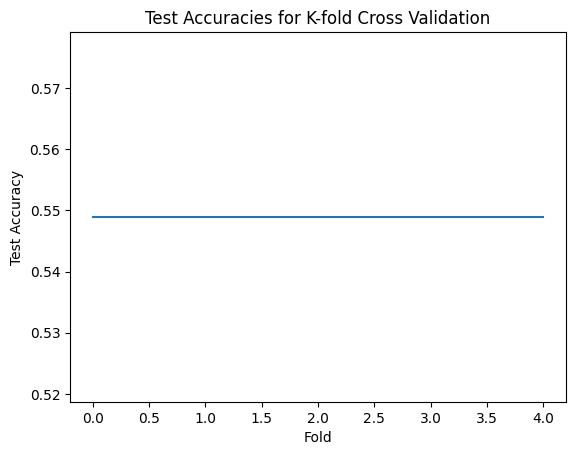

In [24]:
print(test_accuracies)
plt.plot(test_accuracies)
plt.xlabel('Fold')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracies for K-fold Cross Validation')
plt.show()